<a id='top'></a>
***

# 3D Particle Tracking


This aim of this notebook is for the tracking of experimental colloids. It's based on [colloids](https://github.com/yangyushi/colloids), a tracking algorithm developed by Mathieu Leomach, and with modifications from Yushi Yang.

Here is the list of contents for the notebook:

- [Used Packages](#imports)
- [Data Loading](#load)
- [Tracking Menu](#menu)
- [Characterisation](#char)

Before using the notebook, it is important than all the *requirements* to run colloids are previously installed, e.g.,

`pip install -r requirements.txt`

and tahat the colloids' `path` is added to our working `$PATH`. For this, run the following cell:

In [2]:
#Modify the PATH accordingly to import colloids
colloids_path = '/Users/am15146/Documents/Tracking_codes/colloids/python'
path_ = '/Users/am15146/Documents/Tracking_codes/'

import sys
if colloids_path not in sys.path:
    sys.path.append(colloids_path)
    sys.path.append(path_)
import contact_tracking as contacts
from contact_tracking.src import read_lif, menus
from colloids import track, lif

***

### <a id='imports'>Used Packages</a> 

Run the following cell to import all the requirements to execute the tracking. Also, select a `Mode` for displaying figures, e.g., Normal or Interactive. NOTE: For the interactive mode, you might have to run twice the cell below.

<div style="text-align: right">[Go Top](#top)</div>

In [5]:
dmode = menus.interacetive_menu()
dmode

ToggleButtons(description=u'Display mode', index=1, options=('Normal', 'Interactive'), value='Interactive')

In [29]:
import numpy as np
from scipy import ndimage
from itertools import product
import matplotlib.pyplot as plt
import pylab as pl
import imp
from PIL import Image

from scipy import ndimage
from scipy import signal

# from contactAnalysis import figures
if dmode.value == 'Interactive':
    %matplotlib notebook
else:
    %matplotlib inline

***
### <a id='load'>Data Loading</a>

<div style="text-align: right">[Go Top](#top)</div>

In [8]:
data = '/Volumes/Widows/20210201/glassycontacts20210129.lif'
imp.reload(read_lif)
imp.reload(menus)
smenu = menus.Select(data)
smenu.widget

<module 'contact_tracking.src.read_lif' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/read_lif.pyc'>

<module 'contact_tracking.src.menus' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/menus.pyc'>

VBox(children=(Dropdown(description=u'Select Serie', layout=Layout(width=u'max-content'), options=('Image020, 2D, N Channels:1, X:1024, Y:1024', 'Image022, 2D, N Channels:1, X:1024, Y:1024', 'Image024, 2D, N Channels:1, X:1024, Y:1024', 'Image026, 2D, N Channels:1, X:1024, Y:1024', 'Series031, 3D, N Channels:1, X:1024, Y:1024', 'Image003, 2D, N Channels:1, X:512, Y:512', 'Image007, 2D, N Channels:2, X:512, Y:512', 'Image009, 2D, N Channels:2, X:512, Y:512', 'Image011, 2D, N Channels:2, X:512, Y:512', 'zstack-condesed-emulsions, 3D, N Channels:2, X:512, Y:512, Z:183', 'Preview001, 2D, N Channels:2, X:512, Y:512'), value=None), Output()))

***
### <a id='menu'>Tracking Menu</a>

<div style="text-align: right">[Go Top](#top)</div>

In [9]:
menu = menus.MainMenu()
menu.options

VBox(children=(ToggleButtons(description=u'Media Input', options=('Lif', 'Images'), value='Lif'), IntText(value=5, description=u'No. Frames'), IntText(value=0, description=u'Initial frame'), FloatSlider(value=1.6, description=u'k (Blur)', max=10.0, min=1.0, step=0.2), FloatText(value=0.0, description=u'Edge cut'), Checkbox(value=True, description=u'Show plots'), Output()))

In [10]:
imp.reload(read_lif)
reader=read_lif.Reader(data)
S=reader.chooseSerie()

<module 'contact_tracking.src.read_lif' from '/Users/am15146/Documents/Tracking_codes/contact_tracking/src/read_lif.pyc'>

*
Experiment: glassycontacts20210129.lif
(0) Image020: 1 channels and 2 dimensions
 Gray X1024 Y1024
(1) Image022: 1 channels and 2 dimensions
 Gray X1024 Y1024
(2) Image024: 1 channels and 2 dimensions
 Gray X1024 Y1024
(3) Image026: 1 channels and 2 dimensions
 Gray X1024 Y1024
(4) Series031: 1 channels and 3 dimensions
 Gray X1024 Y1024
(5) Image003: 1 channels and 2 dimensions
 Gray X512 Y512
(6) Image007: 2 channels and 2 dimensions
 Gray Gray X512 Y512
(7) Image009: 2 channels and 2 dimensions
 Gray Gray X512 Y512
(8) Image011: 2 channels and 2 dimensions
 Gray Gray X512 Y512
(9) zstack-condesed-emulsions: 2 channels and 3 dimensions
 Gray Gray X512 Y512 Z183
(10) Preview001: 2 channels and 2 dimensions
 Gray Gray X512 Y512

Choose a serie --> 9


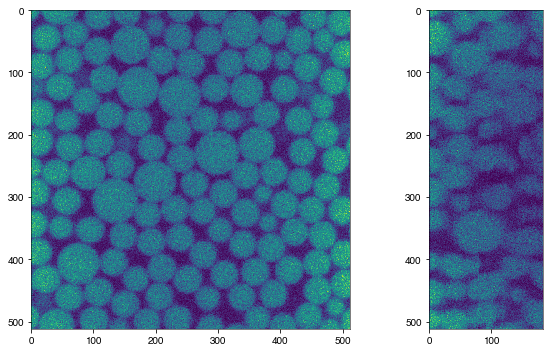

In [147]:
data = '/Volumes/Widows/20210201/centres.tif'

f = 0
nz = 183
z =5
img_obj = Image.open(data)
zxy = []

for i in range(img_obj.n_frames):
    img_obj.seek(i)
    zxy.append(np.array(img_obj.convert('L')))
zxy = np.array(zxy)
xyz = np.moveaxis(zxy, 0, -1)
xyz = xyz[f:xyz.shape[0]-f, f:xyz.shape[1]-f, :nz]  # take only a fraction

fig,axs = pl.subplots(1,2, figsize = (10,5))
axs = axs.ravel()
axs[0].imshow(xyz[:, :, z])
axs[1].imshow(xyz[z, :, :])

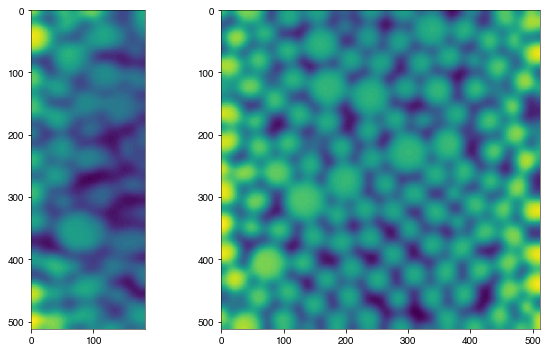

In [173]:
img = ndimage.median_filter(xyz, 3)
img = ndimage.gaussian_filter(img, 7)



fig,axs = pl.subplots(1,2, figsize = (10,5))
axs = axs.ravel()
axs[0].imshow(img[5])
axs[1].imshow(img[:, :, 5])


In [174]:
fix_y = img / np.reshape( img.mean(2).mean(0), (1, img.shape[1], 1) )

fix_z = fix_y / np.reshape( fix_y.mean(0).mean(0), (1, 1, img.shape[2]) )

fix_x = fix_z / np.reshape( fix_z.mean(-1).mean(-1), (img.shape[0], 1, 1) )

fix_x = fix_x / fix_x.max() * 255

roi = tuple([slice(0, xyz.shape[0]), slice(0, xyz.shape[1]), slice(0, None)])
img_ = fix_x[roi]

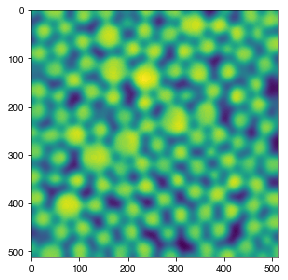

In [175]:
pl.imshow(img_[:,:,0])

In [176]:
finder = track.MultiscaleBlobFinder(shape=img_.shape, Octave0=False)
features = finder(img_)

if len(img_.shape) == 3:
    z, x, y, radii, response = features.T
    centres = np.array((x, y, z)).T
elif len(img_.shape) == 2:
    x, y, radii, response = features.T
    centres = np.array((x, y)).T

    
response_threshold = -2

# only keep partilces whose response is smaller than -2
centres_refined = centres[response < response_threshold]
print(centres.shape, centres_refined.shape)

((246, 3), (237, 3))


In [24]:
def get_fcc_coordinates(number):
    """
    Get the Cartesian cooridnates of a FCC crystal

    Args:
        number (int): the number of particles

    Return:
        np.array: the Cartesian coordinates of FCC crystal, shape (n, 3)
    """
    unit_cell = np.array((
        (0, 0, 0),
        (0, 0.5, 0.5),
        (0.5, 0, 0.5),
        (0.5, 0.5, 0),
    ))
    repeat = int(np.ceil(np.power(number / len(unit_cell), 1.0 / 3.0)))
    indices_1d = list(range(repeat))
    indices_3d = np.array(list(product(indices_1d, repeat=3)))
    unit_cell_num = len(indices_3d)
    coord_3d = np.empty((len(unit_cell) * unit_cell_num, 3))
    for i, atom in enumerate(unit_cell):
        offset = i * unit_cell_num
        coord_3d[
            offset : offset + unit_cell_num
        ] = atom[np.newaxis, :] + indices_3d
    return coord_3d[:number] / coord_3d.max()

def get_fcc_image_noisy(size, number, radius, blur):
    """
    Generate a fake image of many not-overlapping particles
    
    Args:
        size (tuple): the shape of the image, could be in any dimension
        number (int): the number of paritcles in this image
        radius (int): the radius of the particles, assuming paticles are cubes.
        blur (float): sigma value for extra gaussian blur
    
    Return:
        tuple: the n-dimensional image and the positions of the idea gas
    """
    img = np.zeros(size)
    positions_nd = get_fcc_coordinates(number) * (np.array(size)[None, :] - 1)
    for xyz in positions_nd: 
        img[tuple(xyz.astype(int))] = 1 + np.random.random() * 0.4
    img = ndimage.maximum_filter(img, radius)
    img += np.random.exponential(1, img.shape)
    img = ndimage.gaussian_filter(img, blur)
    img += np.random.exponential(1, img.shape) * 0.02
    img = img / img.max() * 255
    return img.astype(np.uint8), positions_nd

def see_slice(image, positions, s, radius, axis=2, sizes=(10, 10)):
    """
    Check the 3D tracking result for a given slice
    
    Args:
        image (np.ndarray): the 3D volumetirc image, shape (x, y, z)
        positions (np.ndarray): the xyz positions of the particles, shape (n, 3)
        s (int): the index of slice to inspect. s = 5 means check the 5th slice
        radius (float or np.ndarray): the radius of the particles.
            if it is a float, then all particles were assumed to have the same radius
            if it is a numpy array, then different particles can have different radii
        axis (int): the axis index along which to take the slices.
            Setting axis=2 means slice along z-axis
        sizes (tuple): the figure size of the final plot
        
    Return:
        None: a figure would be plotted
    """
    fig = pl.figure()
    ax = fig.add_subplot(111)
    to_show = np.moveaxis(image, axis, 0)
    pl.imshow(to_show[s].T,zorder=-1)
    if axis == -1:
        axis = 2
    shown_axes = np.array([i for i in range(3) if i != axis])
    if isinstance(radius, np.ndarray):
        radius_all_particles = radius
    else:
        radius_all_particles = [radius] * len(positions)
    for p, r in zip(positions, radius_all_particles):
        y, x = p[shown_axes]
        z = p[axis]
        dz = abs(z - s)
        if z > s:
            color='r'
        else:
            color='w'
        if dz < r:
            r_slice = np.sqrt(r**2 - dz**2)
            circle = plt.Circle([x, y], radius=r, color=color, fill=None, lw=2)
            ax.add_patch(circle)
    fig.set_size_inches(sizes[0], sizes[1])
    pl.axis('off')
    pl.show()

In [179]:
# import nplocate as nl
# nl.see_slice(img_, centres, s=0, radius=5.5, axis=1)


(array([ 5.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  5.,  0., 14., 44.,
        76., 51.,  9.,  9.,  2.,  3.,  3.,  7.,  6.,  7.]),
 array([ 3.52811456,  4.56764272,  5.60717089,  6.64669905,  7.68622721,
         8.72575537,  9.76528354, 10.8048117 , 11.84433986, 12.88386802,
        13.92339619, 14.96292435, 16.00245251, 17.04198068, 18.08150884,
        19.121037  , 20.16056516, 21.20009333, 22.23962149, 23.27914965,
        24.31867782, 25.35820598, 26.39773414, 27.4372623 ]),
 <a list of 23 Patch objects>)

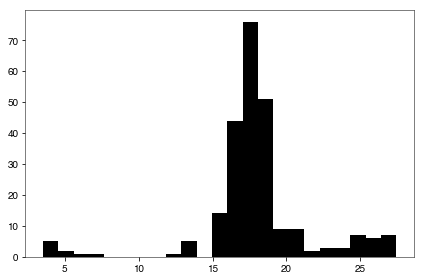

In [180]:
pl.hist(features[:,3],bins = 23)

In [184]:
diameter = int(np.mean(features[:, 3]) * 2)
print(diameter)

gr = nl.get_gr(positions=features[:, :3], cutoff=diameter * 5, bins=50)

35


(0, 5)

Text(0.5,0,u'Distance / $\\sigma$')

Text(0,0.5,u'g(r)')

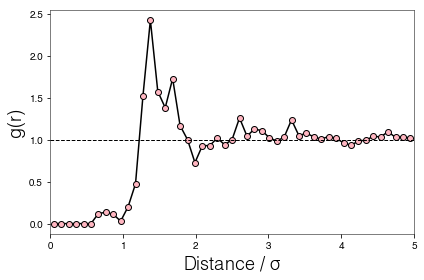

In [185]:
pl.plot(gr[0] / diameter, gr[1], color='k', marker='o', mfc='lightpink')
pl.plot((0, 5), (1, 1), color='k', lw=1, ls='--')
pl.xlim(0, 5)
pl.xlabel('Distance / $\sigma$', fontsize=18)
pl.ylabel('g(r)', fontsize=18)
pl.show()

In [186]:
d_measure = gr[0][np.argmax(gr[1])]

x = 4/3 * np.pi * (d_measure / 2)**3 / (img.shape[0] - d_measure)**3 * features.shape[0]

print('{x:.04} %'.format(x=x * 100))

10.85 %


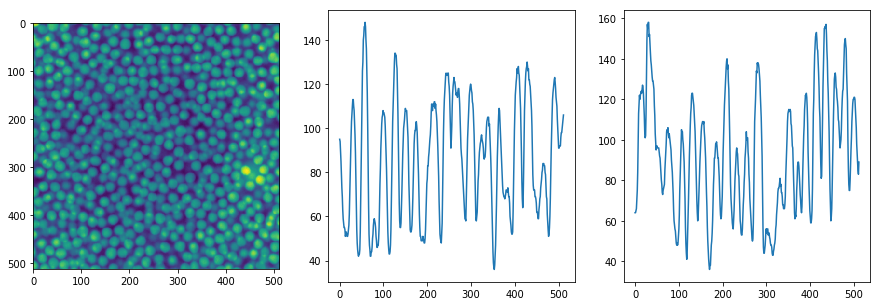

In [108]:
s = 0
fig,axs = pl.subplots(1,3,figsize=(15,5))
axs = axs.ravel()
image_slice = image[:,:,s]
axs[0].imshow(image_slice);
axs[1].plot(image[:,256,s]);
axs[2].plot(image[256,:,s]);

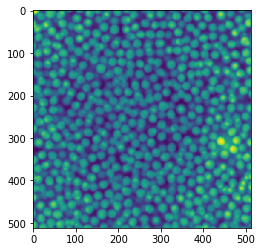

In [88]:
# image_slice = image_slice/np.mean(image_slice)
# image_slice /= image_slice.max()
pl.imshow(image_slice)
# pl.plot(image_slice[:,0]);

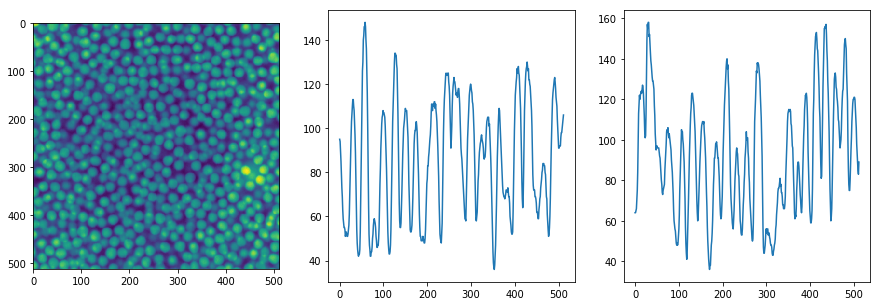

In [109]:
s=0
ZoomOut=ndimage.zoom(image,1)
fig,axs = pl.subplots(1,3,figsize=(15,5))
axs = axs.ravel()
axs[0].imshow(ZoomOut[:,:,s]);
axs[1].plot(ZoomOut[:,256,s]);
axs[2].plot(ZoomOut[256,:,s]);

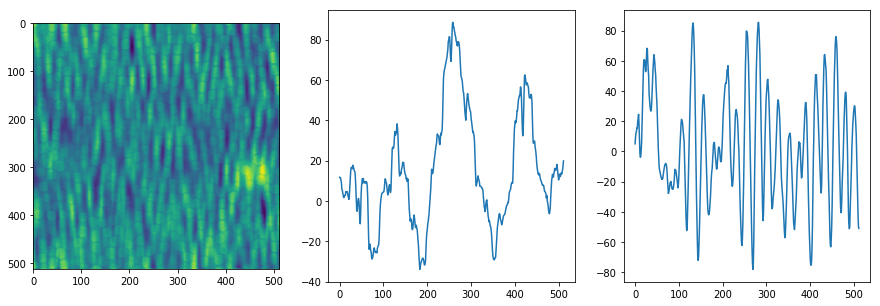

In [124]:
ZoomOut_gau = ndimage.gaussian_filter(ZoomOut,0.5)
decon_k = track.get_deconv_kernel(ZoomOut_gau,k=1.2)
decon = track.deconvolve(ZoomOut_gau,decon_k)
fig,axs = pl.subplots(1,3,figsize=(15,5))
axs = axs.ravel()
axs[0].imshow(decon[:,:,s]);
axs[1].plot(decon[:,256,s]);
axs[2].plot(decon[256,:,s]);

In [136]:
z128 = image[:,:,0]

# filter_k = np.arange(0,1,0.1)
# for i in filter_k:
#     F=ndimage.gaussian_filter(z128,i)
#     finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=3,Octave0=True)
#     centers=finder(F, k=1.7, removeOverlap=True)
#     print "The number of particles is", centers.shape[0],'gaussian=',i

# print
tracking_k = np.arange(1.2,2.9,0.1)
F=ndimage.gaussian_filter(z128,0.2)
for i in tracking_k:
    finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=3,Octave0=True)
    centers=finder(F, k=i, removeOverlap=True)
    print "The number of particles is", centers.shape[0],'k=',i

The number of particles is 592 k= 1.2
The number of particles is 583 k= 1.3
The number of particles is 578 k= 1.4000000000000001
The number of particles is 571 k= 1.5000000000000002
The number of particles is 563 k= 1.6000000000000003
The number of particles is 552 k= 1.7000000000000004
The number of particles is 545 k= 1.8000000000000005
The number of particles is 530 k= 1.9000000000000006
The number of particles is 524 k= 2.000000000000001
The number of particles is 515 k= 2.1000000000000005
The number of particles is 518 k= 2.200000000000001
The number of particles is 513 k= 2.3000000000000007
The number of particles is 514 k= 2.4000000000000012
The number of particles is 514 k= 2.500000000000001
The number of particles is 518 k= 2.6000000000000014
The number of particles is 519 k= 2.700000000000001
The number of particles is 509 k= 2.8000000000000016


In [ ]:
z128 = image[:,:,:]
F=ndimage.gaussian_filter(z128,2.5)
finder=track.MultiscaleBlobFinder(F.shape)
features=finder(F, k=6., removeOverlap=True)
z, x, y, radii, response = features.T
centres=np.array((x, y,radii)).T
# fig,ax = pl.subplots(figsize=(10,10));
# _=ax.imshow(F);
# for x,y,r in centres:
#     circle = plt.Circle([x, y], radius=r, color='r', fill=None, lw=2);
#     _=ax.add_patch(circle);
centres.shape[0]

(array([ 52.,  97., 242.,  45.,   7.]),
 array([5.50088182, 6.36541845, 7.22995507, 8.09449169, 8.95902832,
        9.82356494]),
 <a list of 5 Patch objects>)

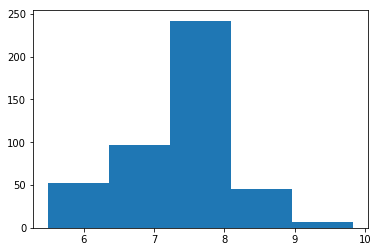

In [152]:
pl.hist(centres[:,2],bins=5)

***
### <a id='char'>Characterisation</a>

<div style="text-align: right">[Go Top](#top)</div>

In [3]:
def draw_circles(xs, ys, rs, **kwargs):
    for x,y,r in zip(xs,ys,rs):
        circle = plt.Circle((x,y), radius=r, **kwargs)
        plt.gca().add_patch(circle)

In [4]:
folders = ['/PhD_3rd/Experiments/STED/2018_04_13/JD1803_1_11phic0_29Cp0_77_decon/',
           '/PhD_3rd/Experiments/STED/2018_04_14/JD1803_1_11phic0_30Cp1_09/JD1803_1_11phic0_30Cp1_09_Series009_t0_decon/',
           '/PhD_3rd/Experiments/STED/2018_04_14/JD1803_1_11phic0_29Cp1_40_pixel0_127/JD1803_1_11phic0_29Cp1_40_pixel0_127_Series019_decon/',       
           '/PhD_3rd/Experiments/STED/2018_04_12/JD1803_1_11phic0_27Cp1_59_decon_t0/',
           '/PhD_3rd/Experiments/STED/2018_04_05/JD1803-1_11_phic0_30Cp1_83_decon/',
           '/PhD_3rd/Experiments/STED/2018_04_13/JD1803_1_11phic0_29Cp1_88_decon/',
           '/PhD_3rd/Experiments/STED/2018_04_10/JD1803-1_11phic0_26Cp1_89_decon/',
           '/PhD_3rd/Experiments/STED/2018_04_11/JD1803_1_11phic0_37Cp2_18_recheck/JD1803_1_11phic0_37Cp2_18_recheck_t0_decon/']

lif_names = ["JD1803_1_11phic0_29Cp0_77_decon.lif",
             "JD1803_1_11phic0_30Cp1_09_Series009_t0_decon.lif",
             "JD1803_1_11phic0_29Cp1_40_pixel0_127_Series019_decon.lif",
             "JD1803_1_11phic0_27Cp1_59_decon_t0.lif",
             "JD1803-1_11_phic0_30Cp1_83_decon.lif",
             "JD1803_1_11phic0_29Cp1_88_decon.lif",
             "JD1803-1_11phic0_26Cp1_89_decon.lif",
             "JD1803_1_11phic0_37Cp2_18_recheck_t0_decon.lif"]

In [4]:
folder='/PhD_3rd/Experiments/STED/2019_03_16/2500rpm_20min_t0_decon/'
READER=lif.Reader(folder+"2500rpm_20min_t0_decon.lif")

In [5]:
folder=folders[6]
READER=lif.Reader(folder+lif_names[6])

In [404]:
data=np.fromfile(folder+"JD1902-mix-Gly_decon_LA32.lif - Series068_decon_c1_sn15_iter2.raw", dtype=np.uint8)
print data.shape[0]/512.**2
FRAME=data.reshape(([598,512,512])).astype(np.int32)

598.0


In [6]:
S=READER.chooseSerie()

Experiment: JD1803-1_11phic0_26Cp1_89_decon.lif
(0) Series022_decon_c1_sn20_iter1: 1 channels and 4 dimensions
 Gray X512 Y512 Z452 T8
(1) Series022_decon_c2_sn20_iter2: 1 channels and 4 dimensions
 Gray X512 Y512 Z452 T8

Choose a serie --> 0


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


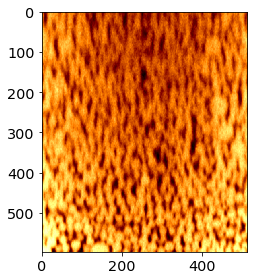

In [12]:
for T in range(7):
    imageC2 = S.getFrame(T)
    plt.imshow(imageC2[:,200,:], plt.cm.afmhot)
    plt.tight_layout()
    plt.savefig(folder+"imageshowc2_y=200_t=%02d.pdf"%T)

In [7]:
t = 1
FRAME=S.getFrame(t)

(598,)


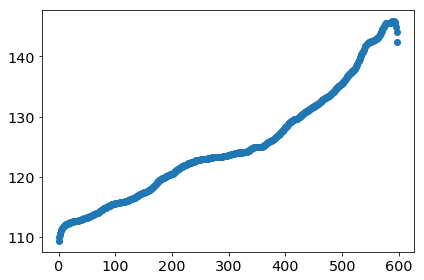

In [15]:
plt.plot(FRAME.mean(axis=(1,2)),'o')
print FRAME.mean(axis=(1,2)).shape
plt.savefig(folder+'t%01d/Image_intensity.pdf'%t)

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


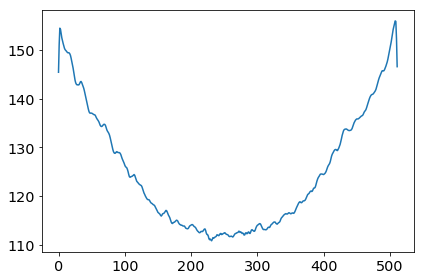

In [7]:
from contactAnalysis import draw_spheres as ds
plt.plot(FRAME.mean(axis=(0,1)))
FRAME_sub = ds.image_substract(FRAME)

In [17]:
from scipy.signal import argrelextrema
intensity_avg = FRAME.mean(axis=(1,2))
local_max = argrelextrema(intensity_avg,np.greater)
local_min = argrelextrema(intensity_avg,np.less)
print local_max[0][0],local_max[0][-1]
print local_min[0]

27 590
[ 29 259 273 285 293 321 327 353 582]


(598,)


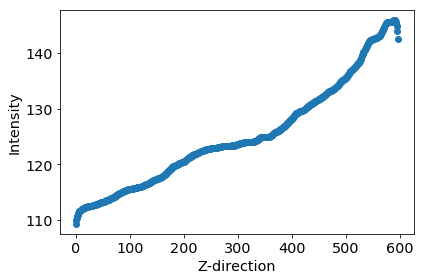

In [18]:
plt.plot(FRAME.mean(axis=(1,2)),'o')
plt.xlabel('Z-direction'),plt.ylabel('Intensity')
print FRAME.mean(axis=(1,2)).shape
plt.savefig(folder+'t%01d/Image_intensity.pdf'%t)

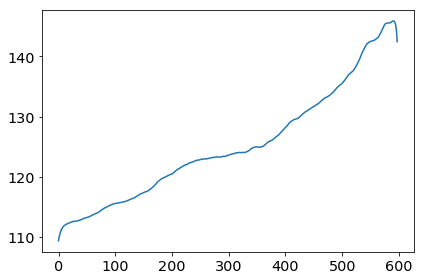

In [19]:
slices = np.array((0,FRAME.shape[0]))
# slices = np.array((49,493))
plt.plot(FRAME[slices[0]:slices[1],:,:].mean(axis=(1,2)),'-')
# imageC2.mean(axis=(1,2)).shape

In [20]:
from copy import deepcopy
import contactAnalysis as ca
from contactAnalysis import draw_spheres as ds

M=deepcopy(FRAME)
target=200
for z in range(slices[0],slices[1]):
    M[z,:,:]=ds.hist_match(FRAME[z, :,:], FRAME[target,:,:])

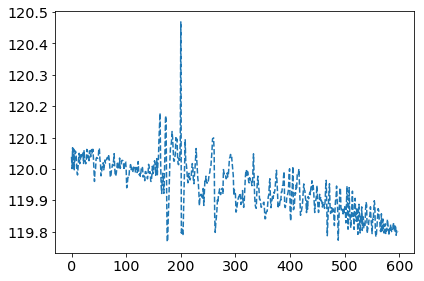

In [21]:
plt.plot(M.mean(axis=(1,2)),'--')
# imageC2.mean(axis=(1,2)).shape

In [8]:
# gau = ndimage.gaussian_filter(FRAME,1.5)
# Filtered=ndimage.gaussian_filter(M128, 0.5)
# ZoomOut=ndimage.zoom(FRAME[slices[0]:slices[1]],0.5)

# ZoomOut=ndimage.zoom(FRAME,0.5)
ZoomOut=ndimage.zoom(FRAME,0.5)
# ZoomOut = ds.image_substract(zoomOut)
print ZoomOut.shape

(226, 256, 256)


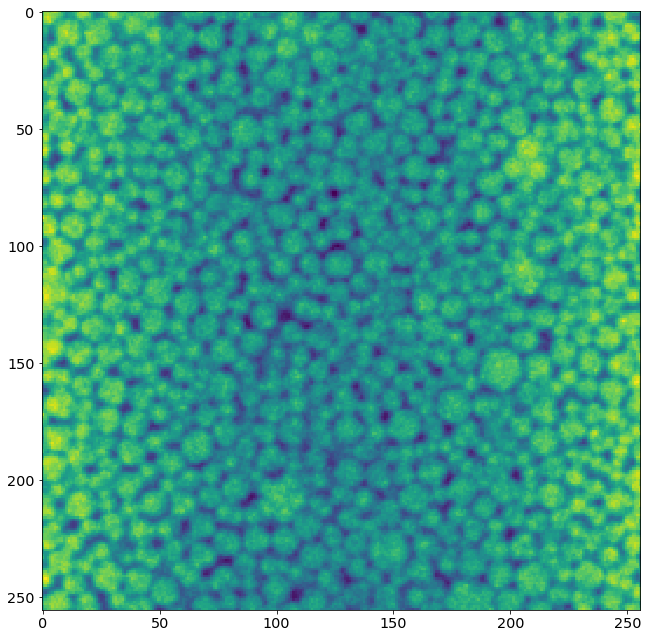

In [9]:
plt.figure(figsize=(9,9))
plt.imshow(ZoomOut[80,:,:])
for ks in np.arange(0.5,2,0.1):
    decon_k = track.get_deconv_kernel(ZoomOut,k=ks)
    for g in np.arange(0.5,2,0.1):
        ZoomOut_gau = ndimage.gaussian_filter(ZoomOut,g)
        decon = track.deconvolve(ZoomOut_gau,decon_k)

        plt.figure(figsize=(9,9))
        plt.imshow(decon[80,:,:])
        plt.savefig(folder+'t%01d/c1/decon/decon_kernal%.2f_gau%.2f.pdf'%(t,ks,g))
        plt.close()

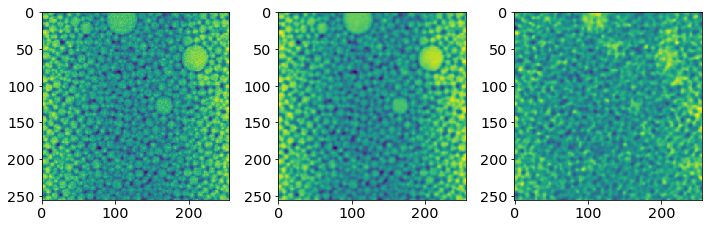

In [16]:
ZoomOut_gau = ndimage.gaussian_filter(ZoomOut,1.2)
decon_k = track.get_deconv_kernel(ZoomOut,k=0.5)
decon = track.deconvolve(ZoomOut_gau,decon_k)
plt.figure(figsize=(10,7))
plt.subplot(1,3,1)
plt.imshow(ZoomOut[102,:,:])
plt.subplot(1,3,2)
plt.imshow(ZoomOut_gau[102,:,:])
plt.subplot(1,3,3)
plt.imshow(decon[102,:,:])

KeyboardInterrupt: 

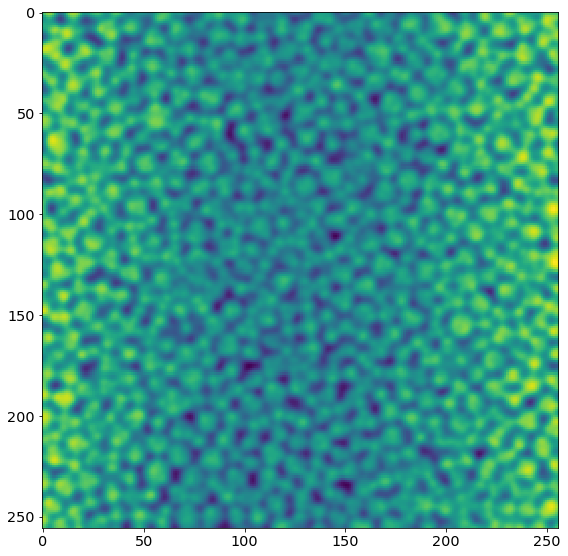

In [223]:
for i in range(ZoomOut.shape[0]):
    plt.figure(figsize=(8,8))
    plt.imshow(ZoomOut_gau[i,:,:])
    plt.savefig(folder+'t0/c1/xy/%04d.tiff'%i)
    plt.close()

In [11]:
z128 = ZoomOut[:128,:100,:100]

In [29]:
filter_k = np.arange(0,1,0.1)
for i in filter_k:
    F=ndimage.gaussian_filter(z128,i)
    finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=3,Octave0=True)
    centers=finder(F, k=1.7, removeOverlap=True)
    print "The number of particles is", centers.shape[0],'gaussian=',i

/Users/jundong/anaconda/lib/python2.7/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


The number of particles is 608 gaussian= 0.0
The number of particles is 608 gaussian= 0.1
The number of particles is 608 gaussian= 0.2
The number of particles is 607 gaussian= 0.30000000000000004
The number of particles is 598 gaussian= 0.4
The number of particles is 597 gaussian= 0.5
The number of particles is 586 gaussian= 0.6000000000000001
The number of particles is 584 gaussian= 0.7000000000000001
The number of particles is 569 gaussian= 0.8
The number of particles is 550 gaussian= 0.9


In [51]:
filter_k = np.arange(0,1,0.1)
for i in filter_k:
    F=ndimage.gaussian_filter(z128,i)
    finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=3,Octave0=True)
    centers=finder(F, k=1.7, removeOverlap=True)
    print "The number of particles is", centers.shape[0],'gaussian=',i

tracking_k = np.arange(1.2,2.9,0.1)
F=ndimage.gaussian_filter(z128,1)
for i in tracking_k:
    finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=3,Octave0=True)
    centers=finder(F, k=i, removeOverlap=True)
    print "The number of particles is", centers.shape[0],'k=',i

The number of particles is 518 k= 1.2
The number of particles is 472 k= 1.3
The number of particles is 452 k= 1.4
The number of particles is 419 k= 1.5
The number of particles is 427 k= 1.6
The number of particles is 380 k= 1.7
The number of particles is 362 k= 1.8
The number of particles is 361 k= 1.9
The number of particles is 355 k= 2.0
The number of particles is 402 k= 2.1
The number of particles is 410 k= 2.2
The number of particles is 420 k= 2.3
The number of particles is 429 k= 2.4
The number of particles is 411 k= 2.5
The number of particles is 417 k= 2.6
The number of particles is 432 k= 2.7
The number of particles is 438 k= 2.8


In [65]:
tracking_k = np.arange(2.5,3,0.1)
F=ndimage.gaussian_filter(z128,0)
for i in tracking_k:
    finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=2,Octave0=True)
    centers=finder(F, k=i, removeOverlap=True)
    print "The number of particles is", centers.shape[0],'k=',i

The number of particles is 447 k= 2.5
The number of particles is 443 k= 2.6
The number of particles is 431 k= 2.7
The number of particles is 422 k= 2.8000000000000003
The number of particles is 429 k= 2.9000000000000004


In [9]:
# F = ZoomOut_gau
F = ndimage.gaussian_filter(ZoomOut,1)

finder=track.MultiscaleBlobFinder(F.shape, nbOctaves=4,Octave0=True)
F.shape
# help(track.MultiscaleBlobFinder)

colloids/track.py:1139: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.preblurred = np.empty(shapes[0], dtype)
colloids/track.py:934: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.layersG = np.empty([nbLayers+3]+list(shape), dtype)
colloids/track.py:935: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.layers = np.empty([nbLayers+2]+list(shape), dtype)


(226, 256, 256)

In [ ]:
centers=finder(F, k=1.4, removeOverlap=True)
print "The number of particles is", centers.shape[0]
print centers.shape
# plt.hist(centers[:,3],bins=50)
# plt.xlabel('Particle Raius')
# plt.show()

In [ ]:
plt.hist(centers[:,3],bins=50)
plt.xlabel('Particle Raius')
plt.show()

In [ ]:
plt.figure(figsize=(11,7))
plt.subplot(2,2,1)
x,y,z = (centers[:,0]).astype(int),(centers[:,1]).astype(int),(centers[:,2]).astype(int)
plt.hist(ZoomOut[z,y,x],bins=100)
plt.xlabel('Image Intensity')

plt.subplot(2,2,2)
plt.hist(centers[:,-1][centers[:,-1]>-3],bins=100)
plt.xlabel('Tracking Intensity')
plt.show()

In [ ]:
reload(figures)
figures.draw_tracked_p_xy(centers,F,folder+'t%01d/c1/xy'%t,factor=1.2,z_space=1.25,test_frame=False)

In [ ]:
all_centers = centers*2    ###### if images are zoomed out 0.5

In [ ]:
np.savetxt(folder+'t%01d/c1/particle_center.txt'%t,all_centers)

In [ ]:
figures.draw_tracked_p_xz(centers,FRAME,folder+'t%01d/c1/xz'%t,factor=1.1,test_frame=False)

In [ ]:
figures.draw_tracked_p_yz(centers,FRAME,folder+'t%01d/c1/yz'%t,factor=1.1,test_frame=False)

In [244]:
import contactAnalysis as ca
from contactAnalysis import analysis,g_r
# g(r), get the cutoff for particle neighbours
r,GR,IGR,IG=g_r.gr(folder+"t%01d/c1/particle_center.xyz"%t,1,1,1)
p_sigma, maxdistance = g_r.first_minimum(GR)
print p_sigma,maxdistance

# file /PhD_3rd/Experiments/STED/2019_03_13/1800rpm-30min_t0-t5_decon/t0/c1/particle_center.xyz
# size before cutting borders: 
# x size: 4 506 
# y size: 5 506 
# z size: 8 592 
# size after cutting borders: 
# x size: 12 498 
# y size: 13 498 
# z size: 17 584 
# Number of Particles: 10455 
# init done 0.169 s
# ideal gas done 1.841 s
# particles done 1.713 s
# bin size: 1.000000 array [1.000000,849.443883]
# number of bins: 849
# binning done 13.722 s
23 31


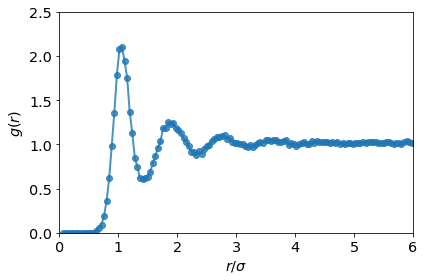

In [234]:
# plt.figure(figsize=(12,9))
plt.plot(r/p_sigma,GR,'o-',alpha=0.8,lw=2)
# plt.plot(r2/(C1[:,-1].mean()*2),GR2,'r--',alpha=0.8,lw=3,label='manual')
plt.xlim(0,6),plt.ylim(0,2.5)
# plt.legend()
plt.xlabel('$r/\sigma$'),plt.ylabel('$g(r)$')
plt.savefig(folder+"t0/c1/gr.pdf")

In [235]:
'Calculate volume fraction'
from contactAnalysis import properties
Factor = p_sigma/2./all_centers[:,3].mean()
print Factor
phi,pd,z_first,z_last = properties.volume_fraction(all_centers,FRAME,factor=Factor,z_range=False)
print phi,pd,z_first,z_last

# figures.pd_hist(all_centers[:,3],folder+'t%01d/c1/'%t,bin_number=100)
f = open(folder+'t%01d/c1/phic_pd_t%01d.txt'%(t,t),'w')
# ff = open('/PhD_3rd/Experiments/STED/2019_03_12/JD1902-mix-Gly_decon_LA32/t0/c1/particle_center.xyz',w)
f.write('%s %s %s' %('phi_c',phi,'\n')) 
f.write('%s %s %s'%('polydispersity',pd,'\n'))
f.close()

1.4132213927578567
11677
0.5047732694490714 0.1423572599044979 0 598


In [4]:
folder = '/Users/am15146/Desktop/XiaoyueDataDinosaur/'

In [52]:
import sys
# sys.path.append( "/Users/christopherroyall/Ursine/Code/colloids/python")
import numpy as np
from glob import glob
from PIL import Image

"""
PARAMETERS!!!
"""

TIME_POINTS = [1, 2, 3, 4, 5, 6, 7, 8]
GAUSSIAN_BLUR = 1
MEDIAN_SIZE = 2
INTENSITY_THRESHOLD = 0.2  # percentage


def load_xyz_from_tiff(folder, t):
    stacks = []
    pattern = folder + "/*_t{t:03}_z*.tif".format(t=t)
    image_files = glob(pattern)
    image_files.sort()
    for fn in image_files:
        img = Image.open(fn)
        stacks.append(np.array(img))
    stacks = np.array(stacks)
    return stacks

if __name__ == "__main__":
    from scipy import ndimage
    import matplotlib.pyplot as plt
    import nplocate as nl
    from colloids import track

#     gr_ensemble = []
#     for t in TIME_POINTS:
#         print("Tracking frame", t)

#         img = load_xyz_from_tiff("/Users/am15146/Desktop/XiaoyueDataDinosaur/", t)

#         """
#         comment the line below to track the un-cut timage
#         """
#         img = img[:128, :128, :128]  # cut the image
#         if MEDIAN_SIZE > 0:
#             img = ndimage.median_filter(img, MEDIAN_SIZE)
#         if GAUSSIAN_BLUR > 0:
#             img = ndimage.gaussian_filter(img, sigma=GAUSSIAN_BLUR)

#         finder = track.MultiscaleBlobFinder(shape=img.shape)
#         result = finder(img, k=1.6)  # (z, x, y, radii, response).T

#         brightness = img[tuple(result[:, :3].astype(int).T)]

#         mask = brightness > img.max() * INTENSITY_THRESHOLD
#         result = result[mask]  # remove dark particles

#         r, gr = nl.get_gr(result[:, :3], cutoff=50, bins=20)
#         gr_ensemble.append((r, gr))

#         nl.save_xyz('coordinates-frame-{t:04}.xyz'.format(t=t), [result[:, :3]])

#     r, gr = gr_ensemble[0][0], np.nanmean([gr[1] for gr in gr_ensemble], axis=0)
#     plt.plot(r, gr)
#     plt.savefig('gr-python.png')



'\nPARAMETERS!!!\n'

In [93]:
directory = '/Volumes/Widows/20210129/'
files = glob(directory + 't_*')
len(files)

13

231


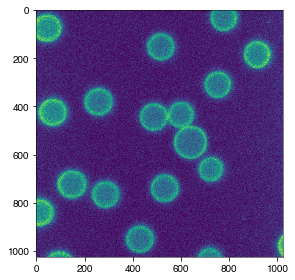

In [98]:
img = np.array(Image.open(files[0]))
pl.imshow(img)
print(img.max())

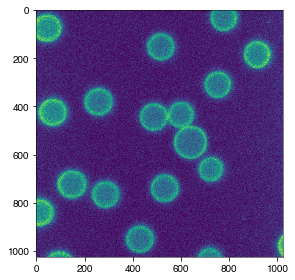

In [99]:
img = img / np.mean(img)
img = img / img.max()
pl.imshow(img)

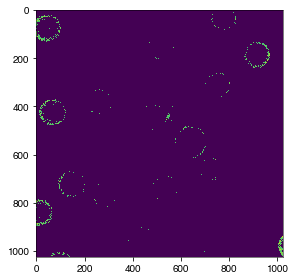

In [100]:
img[img<0.7] = 0.
pl.imshow(img)

In [101]:
n = img >= 0.65
len(img[n])

9950

In [88]:
n[n == True] = 1
n[n == False] = 0
np.sum(n)

21031

In [154]:
lamb = np.linspace(585,609,len(files))

ns = {}
thres = np.arange(0.5,0.9,0.05)

pl.figure()
for i, f in enumerate(files):
    ns.setdefault(lamb[i],{})
    img = np.array(Image.open(f))
        
    m = []
    for j in range(img.shape[0]):
        m.append(img[j].max())
    m = np.array(m)
    pl.errorbar(lamb[i],np.mean(m),yerr = np.std(m),lw=1.5,marker='o',mfc = 'pink',capsize=5,ms = 12,mec='k',c='k');
    
    
    img = img / np.mean(img)
    img = img / img.max()
    for t in thres:
        ns[lamb[i]][t] = len(img[img>=t])
        
pl.xlabel(' Excitation Wavelength $\lambda$ (nm)');
pl.ylabel('Max Intensity');
pl.savefig(directory + 'Intensities.png'.format(t));
pl.close();

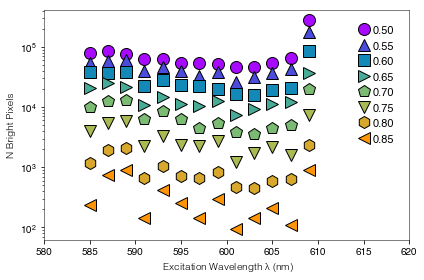

In [158]:
import matplotlib as mpl
from contact_tracking.src.plotting import __purple_banana__
cmap = mpl.colors.ListedColormap(__purple_banana__.__purple_banana__, '__quichi__')
norm = mpl.colors.Normalize(vmin=thres[0],vmax=thres[-1])
cm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
cm.set_array([])

marks = ['o','^','s','>','p','v','h','<']
for w in sorted(ns.keys()):
    for i,t in enumerate(sorted(ns[w])):
        pl.plot(w,ns[w][t],lw=0,marker = marks[i], mfc = cm.to_rgba(t),ms = 12,mec='k');

for i,t in enumerate(thres):
    pl.plot(0,0,lw=0,marker = marks[i], mfc = cm.to_rgba(t),ms = 12,mec='k',label='{:0.2f}'.format(t));

pl.xlim(580,620);
pl.legend(loc = 0);
pl.yscale('log');
pl.xlabel(' Excitation Wavelength $\lambda$ (nm)');
pl.ylabel('N Bright Pixels');
pl.savefig(directory + 'Pixels.png'.format(t));

In [130]:
t

0.8500000000000003